# Scaling Python with Azure ML and Dask

![Describe gif](media/describe.gif)

## Environment setup

This notebook assumes you are using an Azure ML Compute Instance with the default kernel `azureml_py36`. This contains many unneccesary packages. If you want to avoid a long image build time, you may want to create a new conda environment with the minimal packages needed for your scenario. 

It is important that the local environment matches the remote environment to avoid mismatch issues when submitting commands to the remote cluster. To help with this, we will use Azure ML Environments. 

In [ ]:
pip install --upgrade dask[complete] dask-ml[complete] tpot joblib adlfs lz4 distributed fastparquet pyarrow azureml-sdk[notebooks] lightgbm

Uninstall some bugs.

In [ ]:
pip uninstall azureml-samples azureml-mlflow -y

## Important! 

Restart your kernel.

In [ ]:
# this is for a strange bug with compute instances 
import os

os.system('sudo cp /etc/nginx/nginx.conf setup/temp.conf') # stupid

nginx = ''

with open('setup/temp.conf') as f:
    for line in f.readlines():
        if 'websocket/|/ws/' in line:
            nginx += line.replace('websocket/|/ws/', 'websocket/|/ws')
        else:
            nginx += line
       
with open('setup/temp2.conf', 'w') as f:
    f.write(nginx)
    
os.system('sudo mv setup/temp2.conf /etc/nginx/nginx.conf')
os.system('sudo service nginx restart')
os.system('rm setup/temp.conf');

## Imports

Import all packages used in this notebook.

In [1]:
import os
import sys
import dask
import glob
import time
import joblib
import fsspec
import socket
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from IPython.core.display import HTML
from dask_ml.xgboost import XGBRegressor

from azureml.widgets import RunDetails
from azureml.train.estimator import Estimator
from azureml.core.runconfig import MpiConfiguration
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core import Workspace, Experiment, Dataset, Environment, Model

%matplotlib inline

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception cannot import name '_DistributedTraining'.


In [2]:
t_start = time.time()

## Azure ML setup

Get the workspace.

In [3]:
ws = Workspace.from_config()
ws

Workspace.create(name='uks2-azureml', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copeters-rg')

### Data access setup

This is for a ADLS gen2 account I have provisioned with data. It should be read-able publicly.

You **should not** keep storage account keys in plain text format, and you definitely should not upload them to github in a public repo. 

Use the keyvault with the workspace through the Python SDK or Azure Portal to set the account name and key for your storage account, and use the keyvault to retrieve the secrets and pass them through. 

In [4]:
keyvault = ws.get_default_keyvault()
keyvault.set_secret('daskdatakey', 'mupxHTCWrYQC252cFAWCAm7lSlMPTCt5J3j7FCXIlXW/k3OIdLrWssVnMGKVX6N96XoIlw9O8PkQya3cNB9xKw==')

In [5]:
STORAGE_OPTIONS = {
    'account_name': 'data4dask', 
    'account_key' : keyvault.get_secret('daskdatakey')
}

## Enter your name

In [6]:
### name
name        = 'cody'             ### REPLACE
### vnet settings
vnet_rg     = ws.resource_group  # replace if needed
vnet_name   = 'uksouth-vnet'     # replace if needed
subnet_name = 'default'          # replace if needed
### azure ml names 
env_name    = f'{name}-dask-env'
ct_name     = f'{name}-dask-ct'
exp_name    = f'{name}-dask-demo'

### trust but verify
verify = f'''
Name: {name}

vNET RG: {vnet_rg}
vNET name: {vnet_name}
vNET subnet name: {subnet_name}

Environment: {env_name}
Compute target: {ct_name}
Experiment name: {exp_name}
'''

print(verify)


Name: cody

vNET RG: copeters-rg
vNET name: uksouth-vnet
vNET subnet name: default

Environment: cody-dask-env
Compute target: cody-dask-ct
Experiment name: cody-dask-demo



### Create environment 

Create the environment to be used on the remote cluster. 

In [7]:
if env_name not in ws.environments:
    env = Environment.from_existing_conda_environment(env_name, 'azureml_py36')
    env.python.conda_dependencies.add_pip_package('mpi4py') # needed for remote cluster
    env = env.register(ws)
else:
    env = ws.environments[env_name]
    
env.name, env.version

('cody-dask-env', '1')

### Create VM pool

Create Azure ML VM pool for creating remote dask cluster(s).

In [8]:
if ct_name not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    config = AmlCompute.provisioning_configuration(
             vm_size                       = 'STANDARD_D14_V2',    # 8 vCPUS 56 GB RAM 112 GB disk 
             max_nodes                     = 100,
             vnet_resourcegroup_name       = vnet_rg,              # replace if needed
             vnet_name                     = vnet_name,            # replace if needed
             subnet_name                   = subnet_name,          # replace if needed
             idle_seconds_before_scaledown = 300
    )
    ct = ComputeTarget.create(ws, ct_name, config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets[ct_name]
    
ct

AmlCompute(workspace=Workspace.create(name='uks2-azureml', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copeters-rg'), name=cody-dask-ct, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copeters-rg/providers/Microsoft.MachineLearningServices/workspaces/uks2-azureml/computes/cody-dask-ct, type=AmlCompute, provisioning_state=Succeeded, location=uksouth, tags=None)

## Startup cluster

Start the run now. The first time, this will take 

In [9]:
exp = Experiment(ws, exp_name)
est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py',          # sets up Dask cluster
                environment_definition  = env,                 # use same env as local
                node_count              = 50, 
                distributed_training    = MpiConfiguration()
               )
run = next(exp.get_runs()) # use this to get existing run (if kernel restarted, etc)
#run = exp.submit(est)
run

WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


Experiment,Id,Type,Status,Details Page,Docs Page
cody-dask-demo,cody-dask-demo_1579207464_dba57c1d,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## ABFS Setup

In [10]:
protocol  = 'abfs'      # use 'adl' for Azure Data Lake Gen 1
container = 'datasets'  # only contains ISD, GFS is wip 

In [11]:
fs = fsspec.filesystem(protocol, **STORAGE_OPTIONS, container_name=container)

In [12]:
files = []
for file in fs.glob('noaa/isd/year=*/month=*'): # see https://github.com/dask/adlfs/issues/34
    files += fs.ls(f'{file}/')
files = [f'{protocol}://{container}/{file}' for file in files if '2019' not in file] # issue with 2019 data - fix wip 
files[-5:]

['abfs://datasets/noaa/isd/year=2018/month=5/part-00066-tid-9138739344806125380-ef942066-1d58-49f9-8ecb-3329cbe6e57e-383761.c000.snappy.parquet',
 'abfs://datasets/noaa/isd/year=2018/month=6/part-00049-tid-9138739344806125380-ef942066-1d58-49f9-8ecb-3329cbe6e57e-383744.c000.snappy.parquet',
 'abfs://datasets/noaa/isd/year=2018/month=7/part-00107-tid-9138739344806125380-ef942066-1d58-49f9-8ecb-3329cbe6e57e-383859.c000.snappy.parquet',
 'abfs://datasets/noaa/isd/year=2018/month=8/part-00103-tid-9138739344806125380-ef942066-1d58-49f9-8ecb-3329cbe6e57e-383807.c000.snappy.parquet',
 'abfs://datasets/noaa/isd/year=2018/month=9/part-00089-tid-9138739344806125380-ef942066-1d58-49f9-8ecb-3329cbe6e57e-383784.c000.snappy.parquet']

## Scale up with Dask and Azure ML

In [13]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Connect to cluster

In [14]:
# port to forward the dask dashboard to on the compute instance
# we do not use 8787 because it is already in use 
dashboard_port = 4242

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'scheduler' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

if run.get_status() == 'Canceled':
    print('\nRun was canceled')
else:
    print(f'\nSetting up port forwarding...')
    os.system(f'killall socat') # kill all socat processes - cleans up previous port forward setups 
    os.system(f'setsid socat tcp-listen:{dashboard_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &')
    print(f'Cluster is ready to use.')

c = Client(f'tcp://{run.get_metrics()["scheduler"]}')

print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')

waiting for scheduler node's ip

Setting up port forwarding...
Cluster is ready to use.


<Client: 'tcp://10.3.0.8:8786' processes=50 threads=800, memory=5.91 TB>


In [15]:
#c.restart() # restart Client if needed

### Take all the data

In [16]:
df = dask.delayed(dd.read_parquet)(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).compute()
%time df.head()

CPU times: user 400 ms, sys: 17.6 ms, total: 418 ms
Wall time: 13.3 s


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,724755,93129,2008-01-01 00:53:00,37.702,-113.097,1712.0,350.0,3.6,-8.3,1036.2,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
1,724755,93129,2008-01-01 01:53:00,37.702,-113.097,1712.0,340.0,4.1,-11.1,1037.3,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
2,724755,93129,2008-01-01 02:53:00,37.702,-113.097,1712.0,NaN,2.1,-11.7,1039.7,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
3,724755,93129,2008-01-01 03:53:00,37.702,-113.097,1712.0,70.0,1.5,-11.1,1040.3,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
4,724755,93129,2008-01-01 04:53:00,37.702,-113.097,1712.0,NaN,1.5,-13.9,1040.4,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0


In [17]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False)
df = df.persist() # don't run unless dataframe fits comfortably in memory 
%time len(df)

CPU times: user 173 ms, sys: 2.73 ms, total: 176 ms
Wall time: 399 ms


1270243333

In [18]:
%time len(df)

CPU times: user 66.6 ms, sys: 4.19 ms, total: 70.8 ms
Wall time: 258 ms


1270243333

In [19]:
%time df.describe().compute()

CPU times: user 5.74 s, sys: 214 ms, total: 5.96 s
Wall time: 45.9 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.270243e+09,1.270243e+09,1.270243e+09,1.013709e+09,1.053004e+09,1.247780e+09,4.429675e+08,1.133391e+08,4.778603e+07,2.635686e+08,2.635686e+08,6.999535e+06,1.270243e+09,1.270243e+09,1.270243e+09
mean,3.757216e+01,-3.953360e+01,3.982165e+02,1.650804e+02,3.441704e+00,1.197150e+01,1.014653e+03,2.889832e+01,4.276644e+00,8.590938e+00,9.023999e+02,1.885553e+01,2.013246e+03,1.572223e+01,1.000000e+00
std,2.138076e+01,7.862546e+01,5.996861e+02,1.145702e+02,2.869097e+00,1.246356e+01,9.389093e+00,2.905005e+01,2.996370e+00,1.846843e+01,2.849152e+03,3.501295e+01,3.125733e+00,8.811851e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-8.860000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.405000e+01,-9.532000e+01,5.000000e+01,8.000000e+01,2.000000e+00,8.500000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,8.000000e+00,1.000000e+00
50%,4.161600e+01,-7.116000e+01,2.090000e+02,1.900000e+02,3.600000e+00,1.610000e+01,1.017200e+03,4.500000e+01,6.000000e+00,1.000000e+00,0.000000e+00,1.600000e+01,2.015000e+03,1.600000e+01,1.000000e+00
75%,4.920000e+01,1.769700e+01,5.490000e+02,2.800000e+02,5.700000e+00,2.780000e+01,1.026000e+03,7.100000e+01,8.000000e+00,1.200000e+01,9.999000e+03,6.300000e+01,2.018000e+03,2.400000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.018000e+03,3.100000e+01,1.000000e+00


In [20]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 654 ms, sys: 16.4 ms, total: 670 ms
Wall time: 15.7 s
Dataframe is: 626.5GB


In [21]:
%time means = df.groupby(df.index).mean().compute()
means.head()

CPU times: user 477 ms, sys: 23 ms, total: 500 ms
Wall time: 10.9 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
2008-01-01,37.851544,-41.404520,351.706004,176.364994,4.031225,0.791217,1021.312605,29.191647,4.171073,5.199203,47.503108,21.776100,2008.0,1.0,1.0
2008-01-02,37.774122,-40.943714,352.504602,180.436673,4.306232,-0.932920,1021.165374,32.632597,4.152460,5.355434,44.483105,22.627133,2008.0,2.0,1.0
2008-01-03,37.781321,-40.130623,352.634351,156.904648,4.358461,-0.866068,1020.247739,32.471547,4.119097,5.402424,47.639126,23.396628,2008.0,3.0,1.0
2008-01-04,37.879647,-40.516726,353.027684,149.716467,4.318913,1.212171,1017.653427,30.277898,3.897811,5.524803,39.277930,22.328746,2008.0,4.0,1.0
2008-01-05,37.956239,-41.565558,358.450412,161.096456,4.328847,3.918379,1013.838332,30.640481,4.154117,5.342658,39.990708,23.943632,2008.0,5.0,1.0


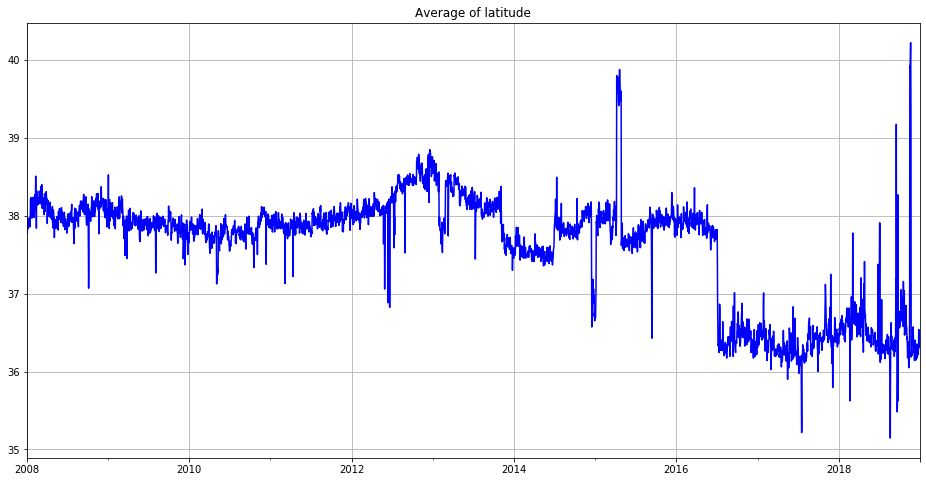

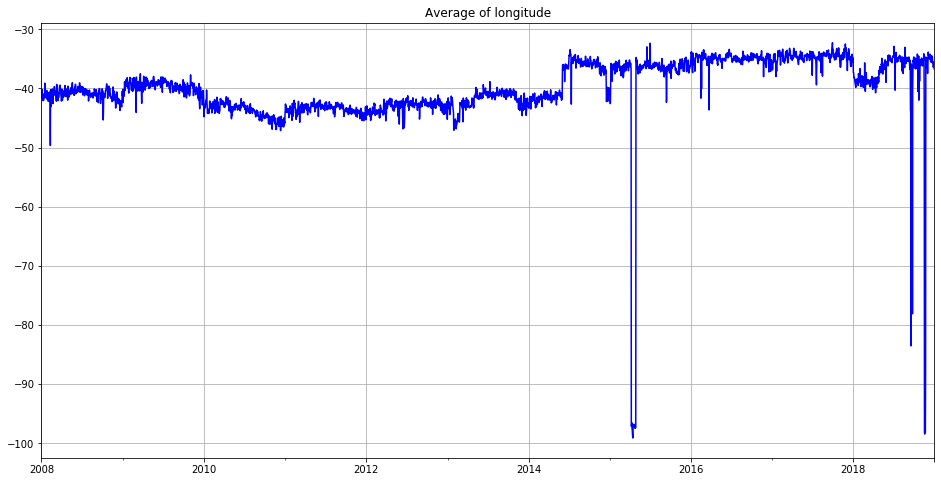

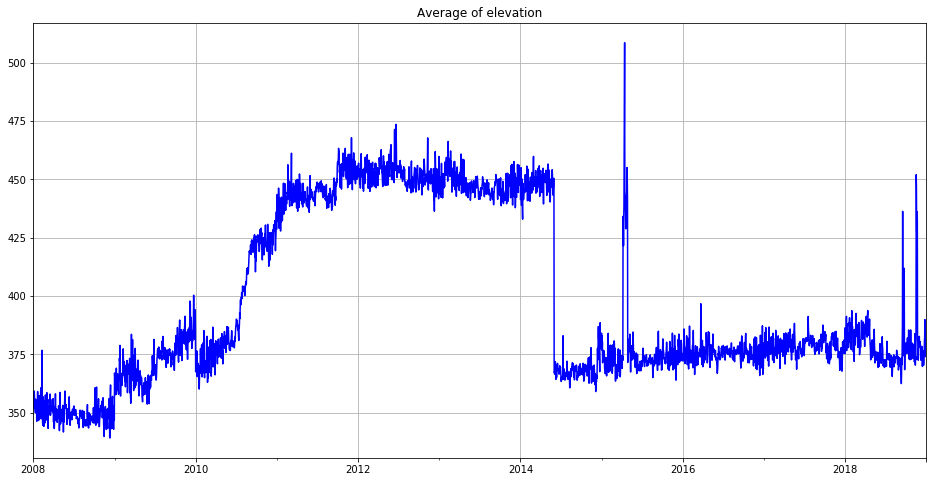

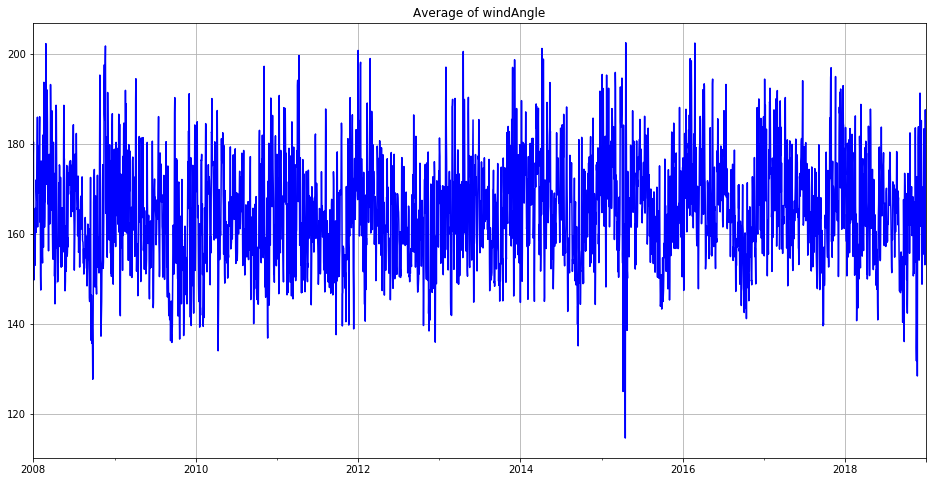

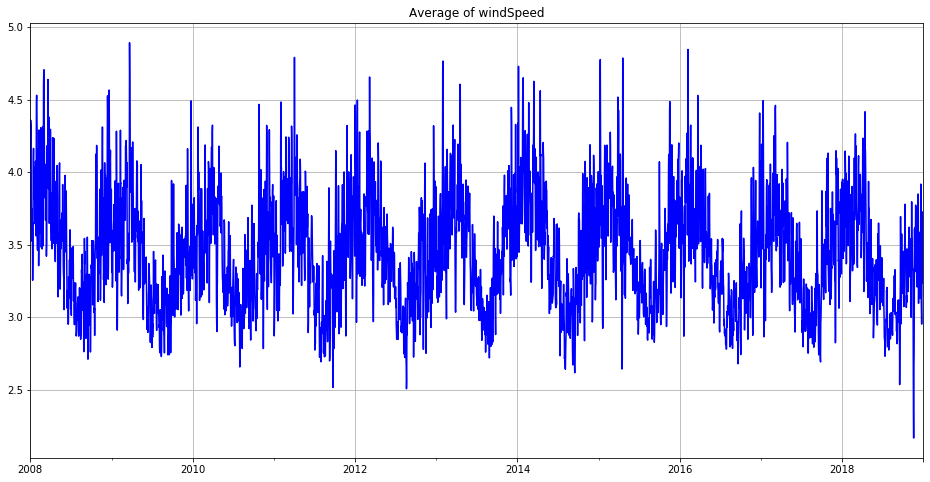

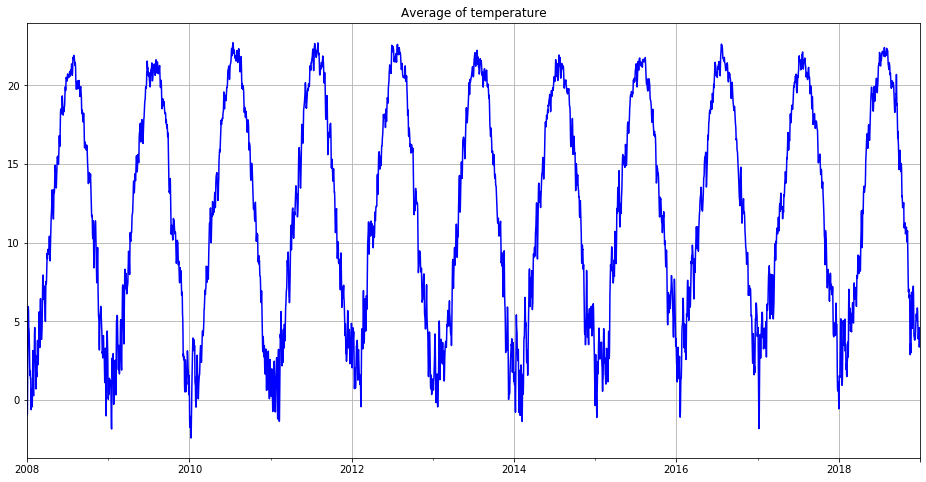

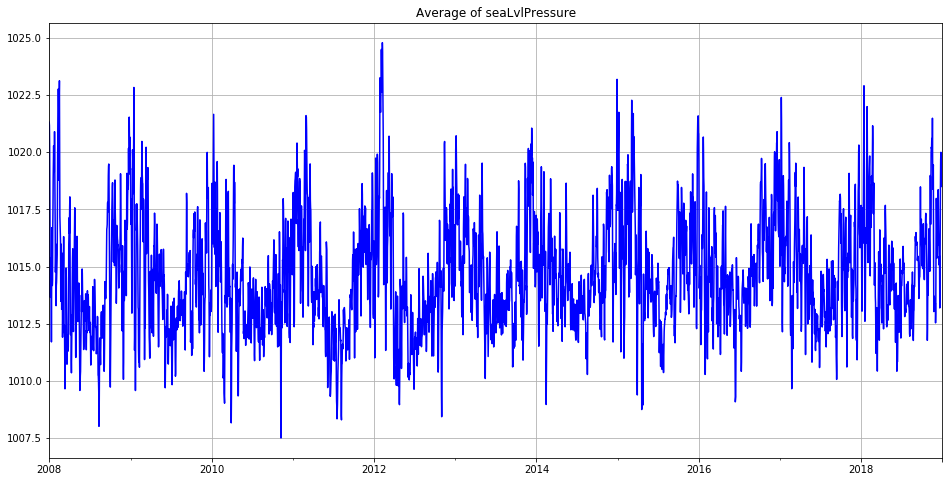

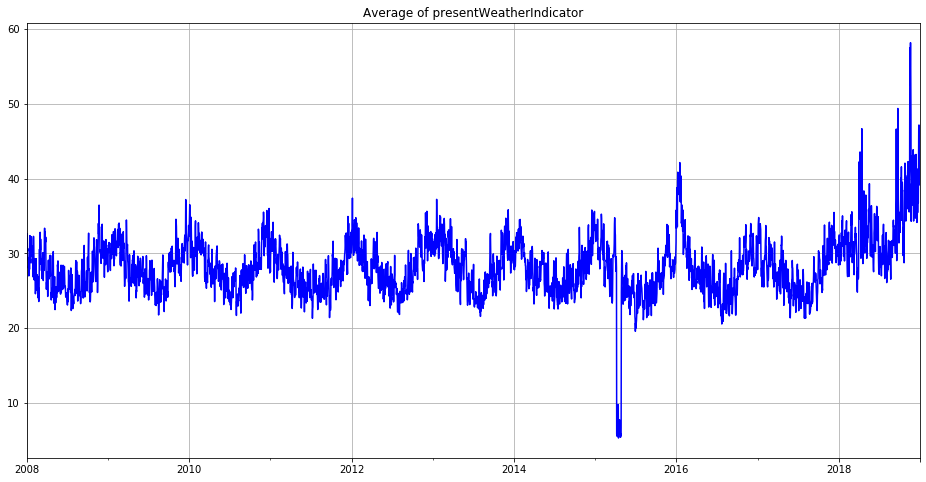

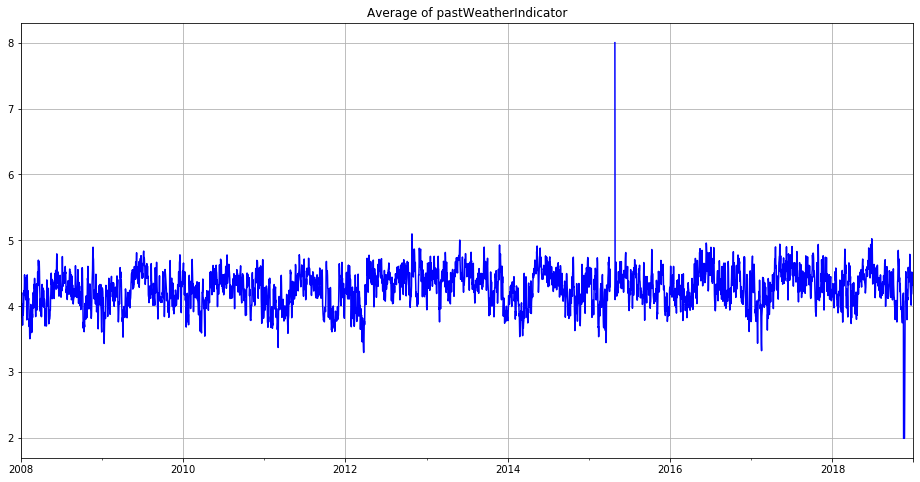

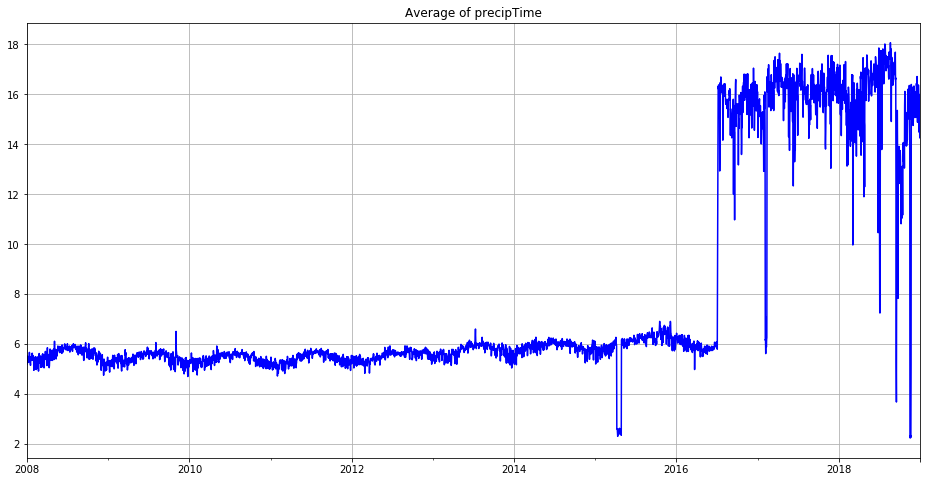

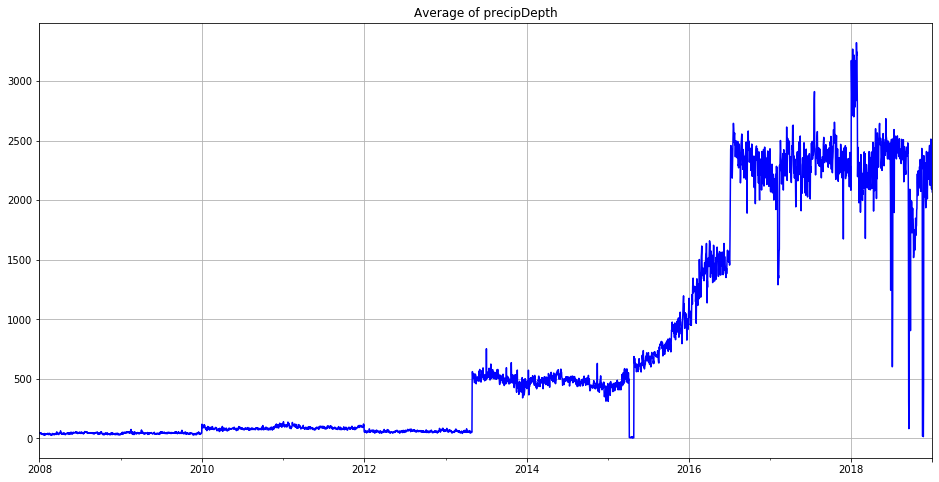

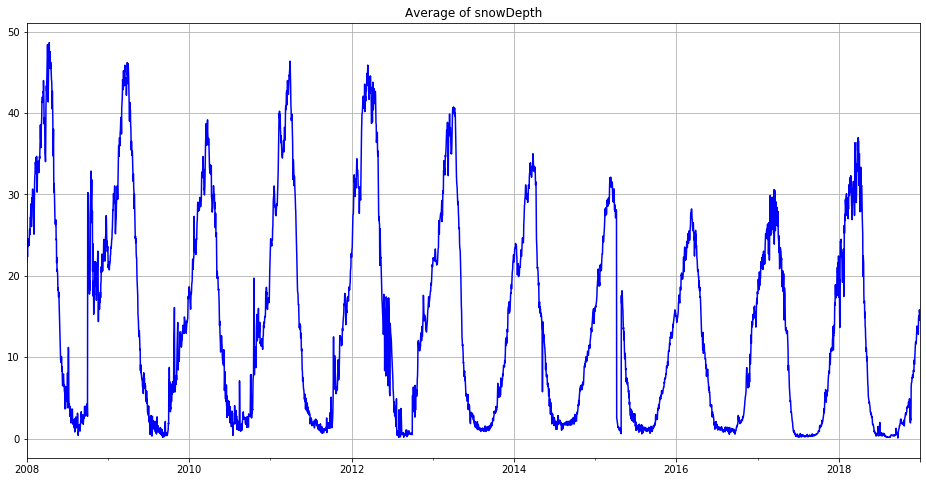

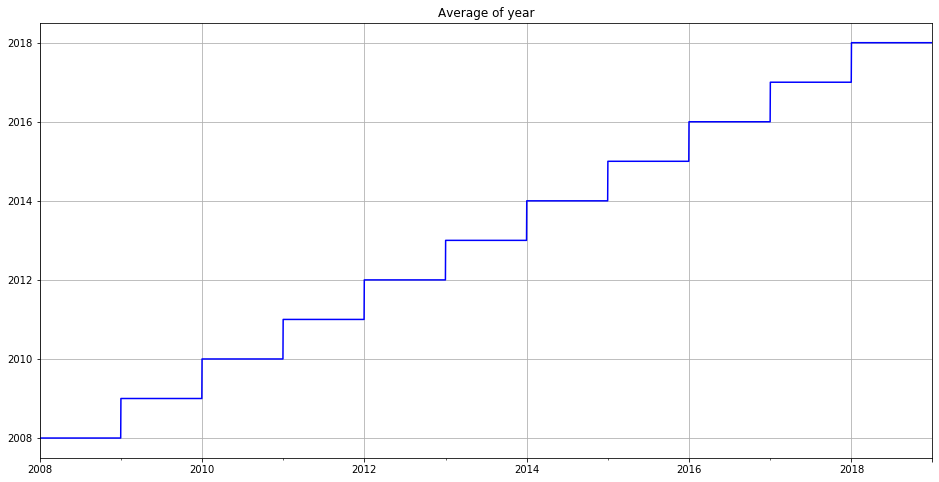

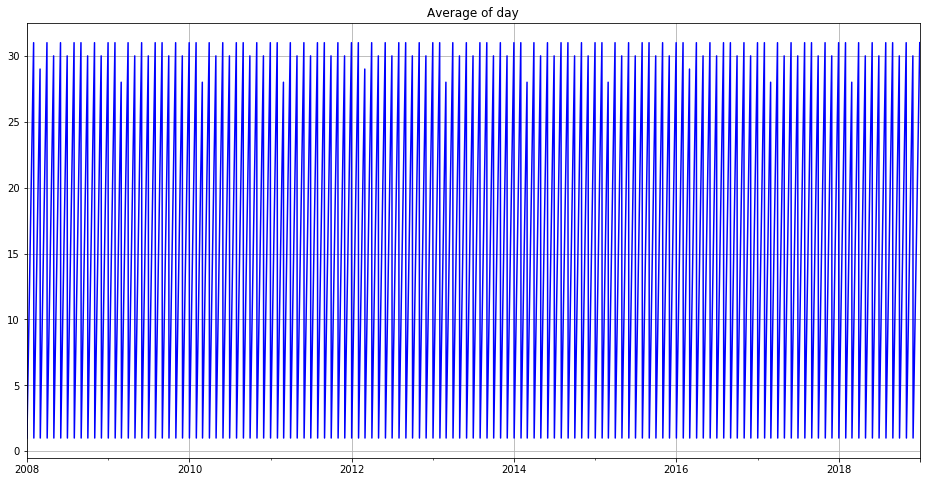

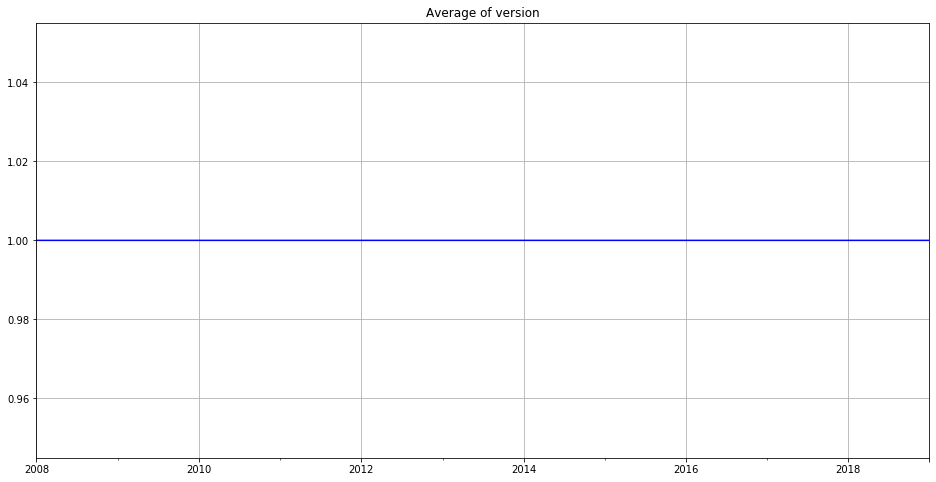

In [22]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime(2018, 12, 31)])
    plt.grid()
    
    # optionally, log the image to the run
    run.log_image(f'mean_{col}', plot=plt)

You can see the images logged to the run in the studio.

In [23]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
cody-dask-demo,cody-dask-demo_1579207464_dba57c1d,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## Prepare data

In [24]:
## insert any Pandas-like Dask data prep code 
df['temperature'] = df['temperature']*(9/5)+32 # 'Merica

## Write data

**Important:** you will have not access to write to this account, get your own storage account! 

See the [API documentation for dask.dataframe.to_parquet](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.to_parquet) for additional settings. 

In [25]:
#df = df.repartition(npartitions=df.npartitions*10)
%time dask.delayed(df.to_parquet)(f'abfs://outputs/noaa/isd_out.parquet', compression='lz4', storage_options=STORAGE_OPTIONS).compute()

CPU times: user 1.91 s, sys: 133 ms, total: 2.04 s
Wall time: 2min


![Write gif](media/write.gif)

## Train XGBoost model

In [26]:
df = dask.delayed(dd.read_parquet)(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).compute()

In [27]:
files = []
for file in fs.glob('noaa/isd/year=*/month=*'): # see https://github.com/dask/adlfs/issues/34
    files += fs.ls(f'{file}/')
files = [f'{protocol}://{container}/{file}' for file in files if '2019' in file] 

df2019 = dask.delayed(dd.read_parquet)(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).compute() 

In [28]:
# begin data prep
df = df.fillna(0) 
df2019 = df2019.fillna(0) 

In [29]:
df['month'] = df['datetime'].dt.month
df2019['month'] = df2019['datetime'].dt.month

In [30]:
cols = list(df.columns)
cols = [col for col in cols if df.dtypes[col] != 'object' and col not in ['version', 'datetime']]
cols

['latitude',
 'longitude',
 'elevation',
 'windAngle',
 'windSpeed',
 'temperature',
 'seaLvlPressure',
 'presentWeatherIndicator',
 'pastWeatherIndicator',
 'precipTime',
 'precipDepth',
 'snowDepth',
 'year',
 'day',
 'month']

In [31]:
X = df[[col for col in cols if col not in ['temperature']]].persist()
y = df.temperature.persist()
# end data prep - persist intelligently per https://docs.dask.org/en/latest/best-practices.html

In [32]:
xgb = XGBRegressor(n_estimators=16)
%time xgb.fit(X, y)

CPU times: user 688 ms, sys: 71.8 ms, total: 760 ms
Wall time: 3min 55s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=16,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [33]:
%time y_pred = xgb.predict(X).compute()

CPU times: user 5.74 s, sys: 3.36 s, total: 9.1 s
Wall time: 11.1 s


In [34]:
rmse = (((y.to_dask_array().compute()-y_pred)**2).mean())**.5 # runs locally, distribute (?)
print(f'Training RMSE: {round(rmse, 3)}')

Training RMSE: 8.489


## Evaluate model

In [35]:
X_test = df2019[[col for col in cols if col not in ['temperature']]].persist()
y_test = df2019.temperature.persist()

In [36]:
%time y_pred = xgb.predict(X_test).compute()

CPU times: user 3.05 s, sys: 509 ms, total: 3.55 s
Wall time: 32 s


In [37]:
rmse = (((y_test.to_dask_array().compute()-y_pred)**2).mean())**.5 # runs locally, distribute (?)
print(f'Test RMSE: {round(rmse, 3)}')

Test RMSE: 8.619


## Register model

In [38]:
model_path = 'xgboost_noaa_isd.joblib.dat'
joblib.dump(xgb, model_path)
#xgb = joblib.load(model_path)

['xgboost_noaa_isd.joblib.dat']

In [39]:
model = Model.register(ws, model_path, 'xgboost-noaa-isd', 
                       description='Dask XGBoost NOAA ISD temperature predictor',
                       model_framework='XGBoost')

Registering model xgboost-noaa-isd


## End the run

Cluster will return to 0 nodes.

In [40]:
c.close()
run.cancel()

In [41]:
t_end = time.time()
print(f'Total run time: {round((t_end-t_start)/60, 2)} minutes')

Total run time: 13.51 minutes
